In [1]:
import numpy as np
import extended_cir
import loan_simulation
import matplotlib.pyplot as plt
import pandas as pd
file_path = "data.xlsx"
ir_termS = pd.read_excel(file_path, sheet_name='interest_rate_term_structure')
cr_termS = pd.read_excel(file_path, sheet_name='credit_risk_term_structure')
ir_params = pd.read_excel(file_path, sheet_name='interest_rate_parameters')
cr_params = pd.read_excel(file_path, sheet_name='credit_risk_parameters')
liquidity_risk_bps = 0.003
risk_margin_bps = 0.005
extended_cir.np.random.seed(100)
max_loan_term = 60
ir_model = extended_cir.InterestRateCIRPP(ir_termS, ir_params['k'][0], ir_params['theta'][0], ir_params['sigma'][0], ir_params['x0'][0])
cr_model = extended_cir.CreditRiskCIRPP(ir_termS, cr_termS, cr_params['k'][0], cr_params['theta'][0],
                                       cr_params['sigma'][0], cr_params['x0'][0], cr_params['recovery_rate'][0], cr_params['premium_frequency'][0])
# TODO Move the below params and the bps above to excel
simulations = 10
time_step = 1/12
T = 5
rho = 0.3

ssrd = extended_cir.SSRDSimulation(ir_model, cr_model, rho, simulations, time_step, T)

In [2]:
xt, yt, rt, ct, ft = ssrd.simulateMC()
ft += liquidity_risk_bps
ft += risk_margin_bps

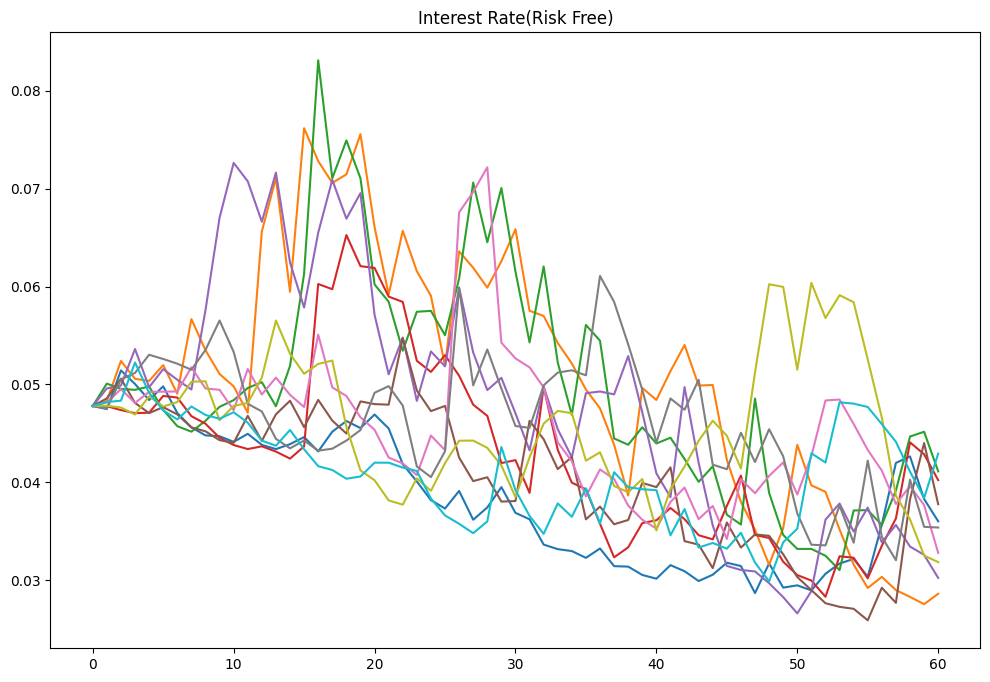

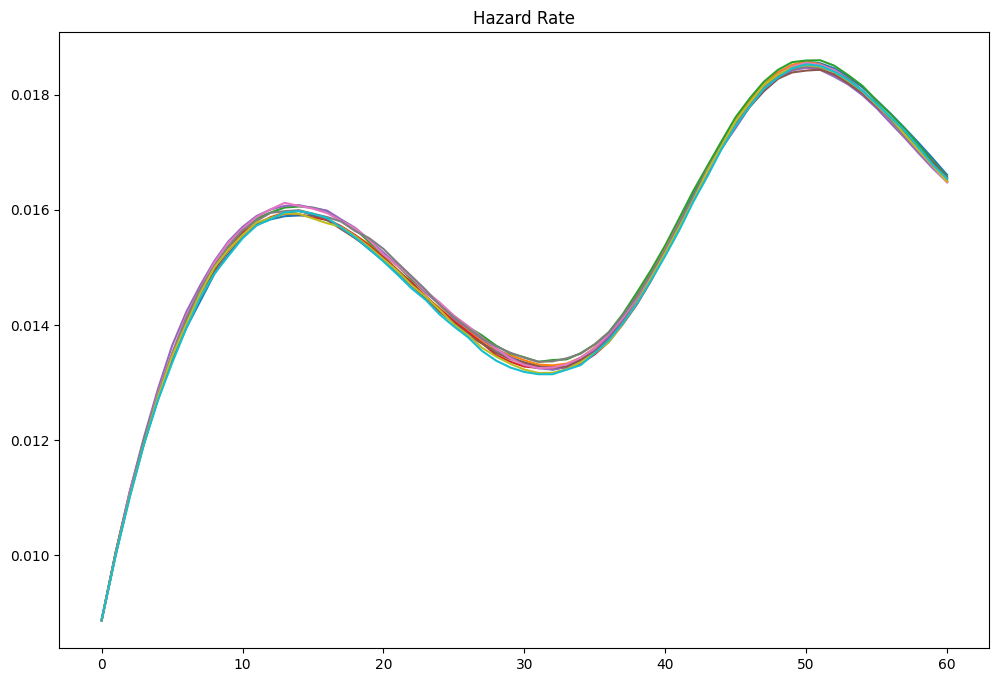

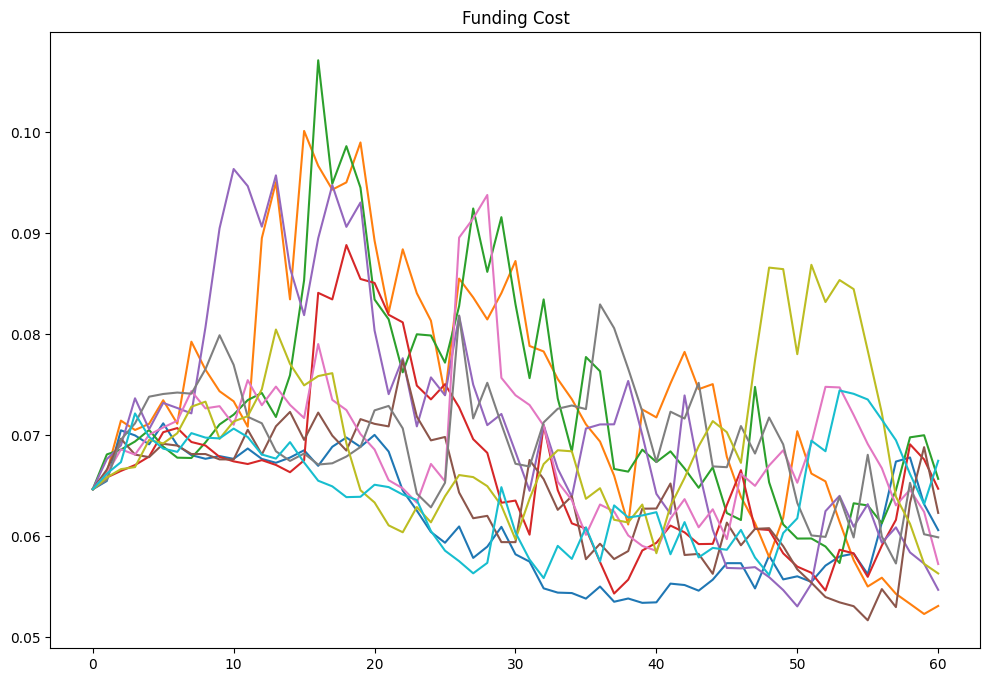

In [3]:
plt.figure(figsize=(12,8))
plt.plot(rt.T)
plt.title("Interest Rate(Risk Free)")
plt.figure(figsize=(12,8))
plt.plot(ct.T)
plt.title('Hazard Rate')
plt.figure(figsize=(12,8))
plt.plot(ft.T)
plt.title('Funding Cost');

In [4]:
loan_simulation.np.random.seed(123)
loan_sim = loan_simulation.LoanBookSimulation(60, 10 * 1e7, 0.5)
loan_sim.simulate_loan_book()
loan_book = loan_sim.loan_book_segmentation();

In [5]:
# rt_avg = []
# max_months = len(rt[0])
# for i in range(max_months):
#     #something wrong in this calculation
#     rt_avg.append(sum(rt[:, i])/len(rt[:, i]))

def yearly_to_monthly_rate(rate):
    return (1+rate)**(1/12) - 1

def survivorship(loan_rate, interest_rate, month_index):
    # precompute it consider future period average and compare with this period value, decide if we should exercise or not
    return loan_rate <= interest_rate
    # s = loan_rate <= interest_rate
    # if month_index >= len(rt_avg) - 1:
    #     return s
    # else:
    #     return s or loan_rate <=rt_avg[month_index+1]

In [6]:
def calculate_clv(loan_tranche):
    loan_amount = sum(loan_tranche['loan_amount'])
    fixed_rate = sum(loan_tranche['fixed_rate'])/len(loan_tranche['fixed_rate'])
    loan_term = int(sum(loan_tranche['loan_term'])/len(loan_tranche['loan_term']))
    monthly_rate = fixed_rate/12
    clvs = []
    loan_life = []
    emi = loan_amount*(monthly_rate*(1+monthly_rate)**loan_term)/((1+monthly_rate)**loan_term - 1)
    for sim_num in range(simulations):
        clv = np.zeros(max_loan_term)
        last_month = loan_term
        outstanding_principal = loan_amount
        for month in range(1, loan_term+1):
            monthly_interest = outstanding_principal * monthly_rate
            principal_component = emi - monthly_interest
            outstanding_principal -= principal_component
            funding_cost = 1 + yearly_to_monthly_rate(ft[sim_num, month])
            cf = monthly_interest/(funding_cost**month)
            if not survivorship(fixed_rate, rt[sim_num, month], month-1):
                last_month = month
                clv[month-1:max_loan_term] = clv[month-2]+3*cf
                break
            clv[month-1:max_loan_term] = clv[month-2]+cf
        clvs.append(clv)
        loan_life.append(last_month)

    return np.array(clvs), np.array(loan_life)

In [7]:
# i = len(rt_avg) - 1
# interest_rate_sum = rt_avg[i]
# i-=1
# l = len(rt_avg)
# while(i>0):
#     interest_rate_sum += rt_avg[i]
#     rt_avg[i] = interest_rate_sum/(l-i)
#     i-=1
# plt.plot(rt_avg)

In [8]:
loan_tranches = loan_sim.split_loan_into_tranches(loan_book)

In [22]:
tranche_clvs = []
labels = []
for key, loan_tranche in loan_tranches.items():
    clvs, loan_life = calculate_clv(loan_tranche)
    labels.append(key)
    tranche_clvs.append(clvs.mean(axis=0))
tranche_clvs = np.array(tranche_clvs)
labels = np.array(labels)

In [25]:
high_clv_indices = np.argsort(tranche_clvs[:, max_loan_term-1])
high_clv_indices = high_clv_indices[::-1]

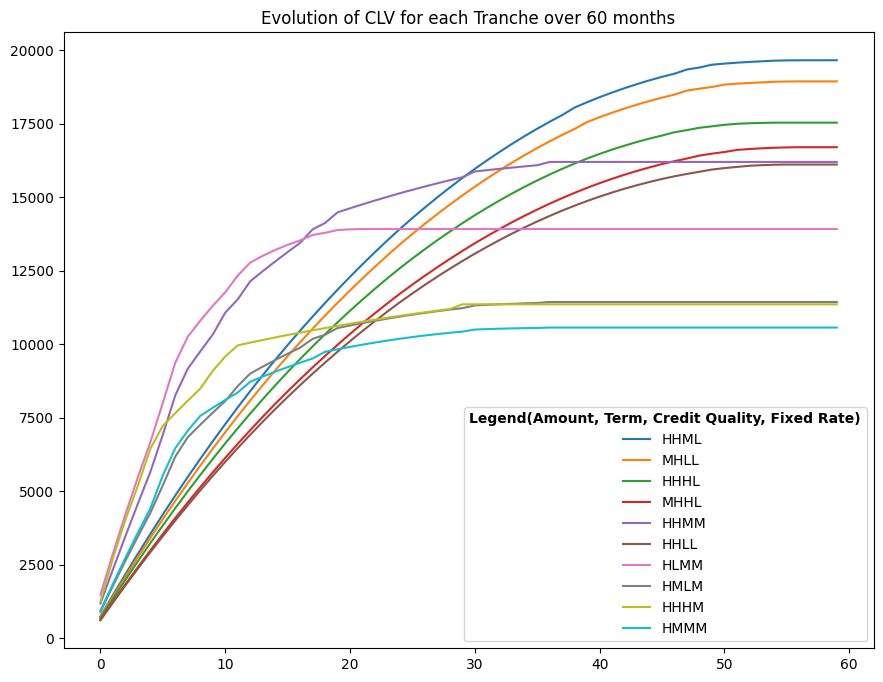

In [76]:
# have to plot each tranche in 60 months, 81 rows 60 columns
top_clvs_to_display = 10
plt.figure(figsize=(12,8))
plt.plot(tranche_clvs[high_clv_indices[:top_clvs_to_display]].T, label=labels[high_clv_indices[:top_clvs_to_display]]);
plt.title('Evolution of CLV for each Tranche over 60 months');
leg_title="Legend(Amount, Term, Credit Quality, Fixed Rate)"
leg = plt.legend(title=leg_title)#, loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(leg.get_title(), weight='bold')
# plt.subplots_adjust(right=0.8)
plt.show()